In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from inpainting.visualizations import samples as vis
from inpainting.visualizations.digits import img_with_mask
import pandas as pd
from inpainting.evaluation import evaluation as ev
from tqdm import tqdm
from itertools import chain
from inpainting.evaluation.frechet_models import MNISTNet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from inpainting.evaluation import fid
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

In [4]:
mnist_experiments_paths = {
#     "misgan": Path("../results/mnist/misgan/"),
    "torch_mfa": Path("../../gmm_missing/models/mnist_28_28"),
#     "gmm_fullconv": Path("../results/mnist/long_trainings/fullconv_v1"),
    "gmm_linear_heads": Path("../results/mnist/long_trainings/linear_v1"),
}

# celeba_32_experiments_paths = {
#     "gmm_linear_heads" = Path("../results/celeba/linear_heads/32x32/scripted_v2_after_fix"),
#     "gmm_fullconv" = Path("../results/celeba/fullconv/32x32/scripted_v2_after_fix"),
#     "torch_mfa" = Path("../../gmm_missing/models/celeba_32_32")
# }

experiments_paths = mnist_experiments_paths

In [5]:
experiments_results = dict()

for (name, path) in experiments_paths.items():
    with (path / "val_predictions_10x15.pkl").open("rb") as f:
        experiments_results[name] = pickle.load(f)

In [6]:
x, j, p, m ,a, d, y = experiments_results["torch_mfa"][0]

In [7]:
# [t.shape for t in [x, j, p, m, a, d, y]]

In [8]:
experiments_images = dict()

for (name, results) in experiments_results.items():
    experiments_images[name] = [(ev.outputs_to_images(*r), r[-1]) for r in results]

# NLL and MSE

In [9]:
ml_metrics = {
    name: [
        (ev.loss_like_metrics(res), res)
        for res in results
    ]
    for name, results in tqdm(experiments_results.items())
}

100%|██████████| 2/2 [01:56<00:00, 58.08s/it]


In [10]:
ml_metrics_df = pd.DataFrame([
    {
        "imputer_model": f"{model}_10x15",
#         "smieja_nll": m[1][-1][1] if len(m[1][-1].shape) > 0 else None,
        **m[0]
    }
    for model, metrics in ml_metrics.items()
    for m in metrics
])

ml_metrics_df#[ml_metrics_df.imputer_model == "gmm_linear_heads"]

,imputer_model,nll,mse,signed_diff_mean,signed_diff_std
0,torch_mfa_10x15,-130.529663,2.615683,-0.004906,0.132404
1,torch_mfa_10x15,-57.761097,19.548357,0.043970,0.359515
2,torch_mfa_10x15,-254.421432,1.111115,-0.007464,0.086029
3,torch_mfa_10x15,56.037418,13.785007,0.034829,0.302152
4,torch_mfa_10x15,241.096893,22.705030,-0.118332,0.371869
...,...,...,...,...,...
19995,gmm_linear_heads_10x15,-201.823639,7.375888,-0.092237,0.202331
19996,gmm_linear_heads_10x15,-89.032646,15.216880,0.008852,0.319449
19997,gmm_linear_heads_10x15,-354.759216,6.961528,-0.048630,0.210573
19998,gmm_linear_heads_10x15,-509.868195,3.210490,-0.054471,0.136235


In [11]:
ml_metrics_df.agg(["mean", "std"])

,nll,mse,signed_diff_mean,signed_diff_std
mean,-70.721769,10.569160,-0.001681,0.245403
std,378.579636,7.992935,0.050619,0.090165


In [12]:
ml_metrics_df[["imputer_model", "nll", "mse"]].to_csv("mnist_nll.csv")

In [13]:
mfa_df = ml_metrics_df[ml_metrics_df.imputer_model == "torch_mfa"]
mfa_df

,imputer_model,nll,mse,signed_diff_mean,signed_diff_std


In [14]:
ml_metrics_df.groupby("imputer_model").agg(["mean", "std"]).to_csv("mnist_summary.csv")
ml_metrics_df.groupby("imputer_model").agg(["mean", "std"])

nll                    mse            \
                              mean         std       mean       std   
imputer_model                                                         
gmm_linear_heads_10x15 -147.297330  498.068974   9.045894  5.018791   
torch_mfa_10x15           5.853791  163.883818  12.092426  9.897020   

                       signed_diff_mean           signed_diff_std            
                                   mean       std            mean       std  
imputer_model                                                                
gmm_linear_heads_10x15        -0.004398  0.050735        0.230926  0.069093  
torch_mfa_10x15                0.001035  0.050360        0.259879  0.105201

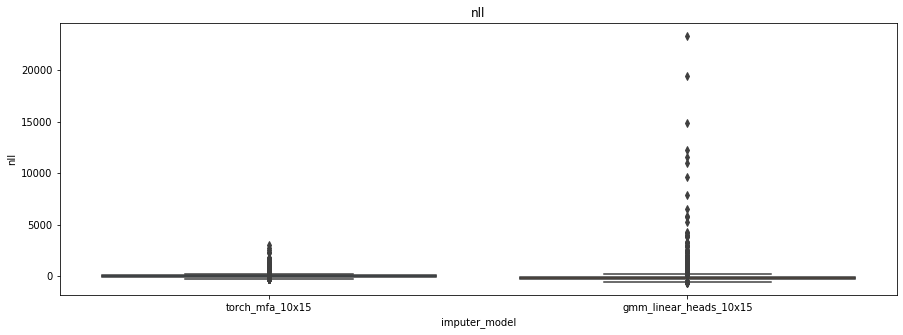

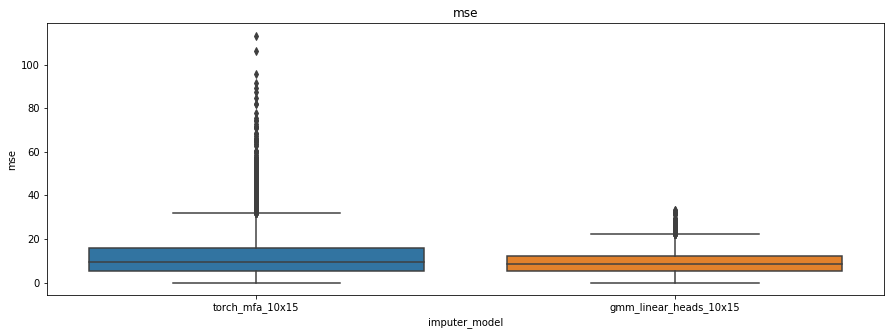

In [15]:
for metric in ["nll", "mse"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=ml_metrics_df,
        y=metric,
        # x="img_kind",
        x="imputer_model"
    )
    plt.show()

# Worst and best NLL cases for every model

torch_mfa worst 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


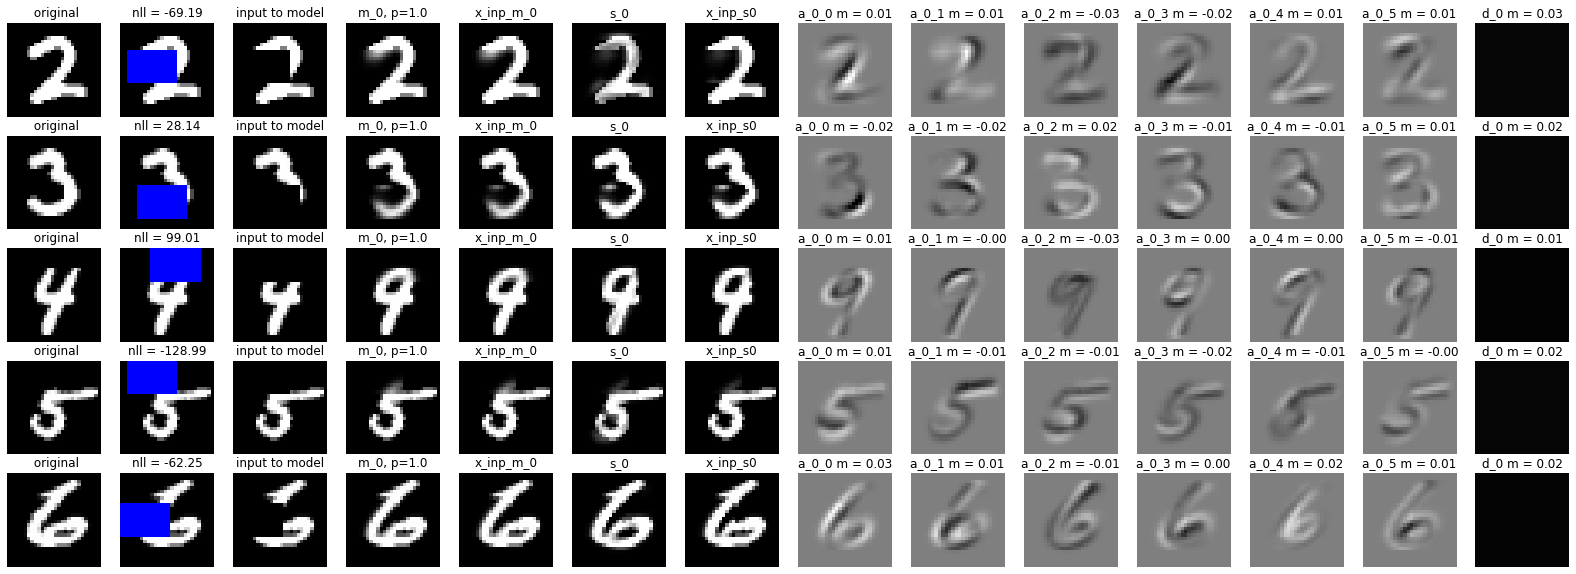

torch_mfa best 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


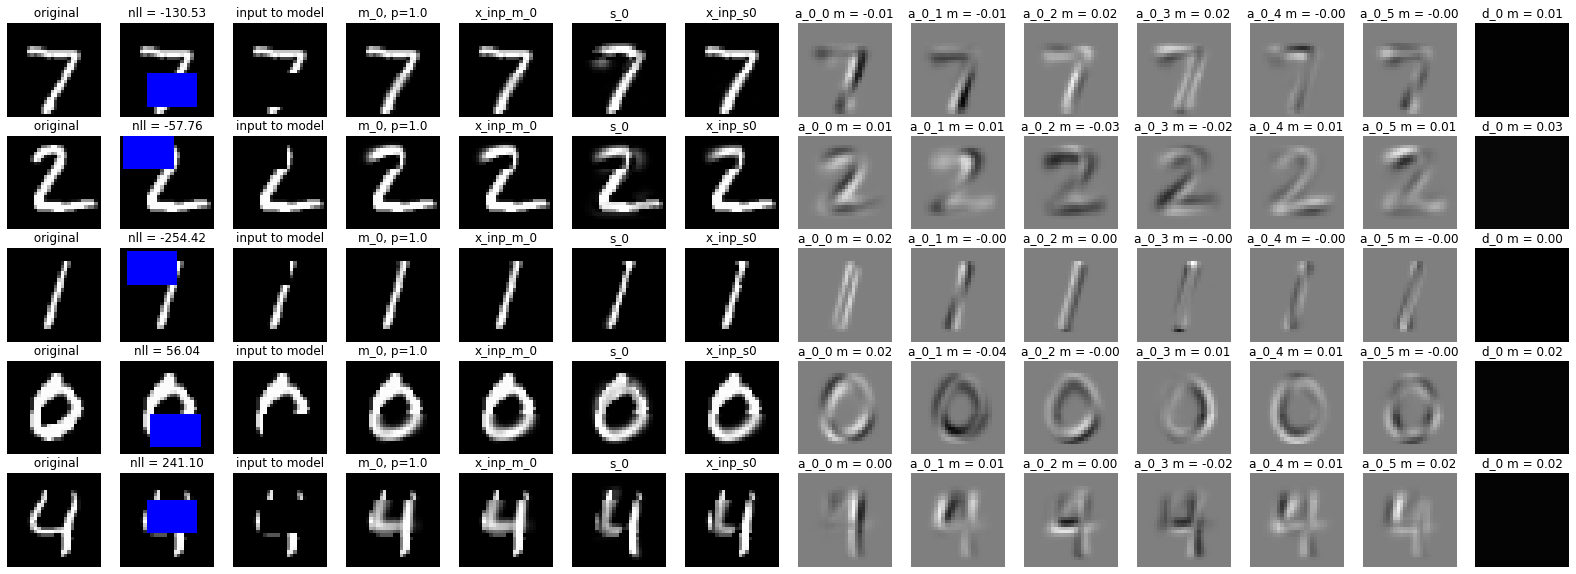

gmm_linear_heads worst 5


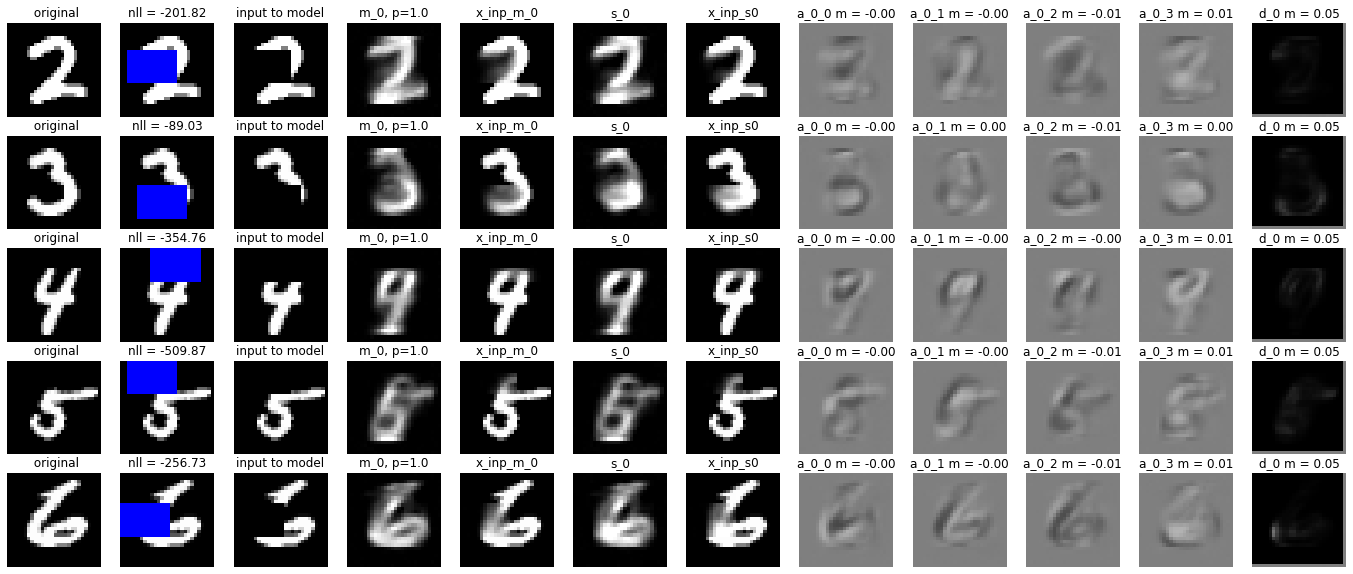

gmm_linear_heads best 5


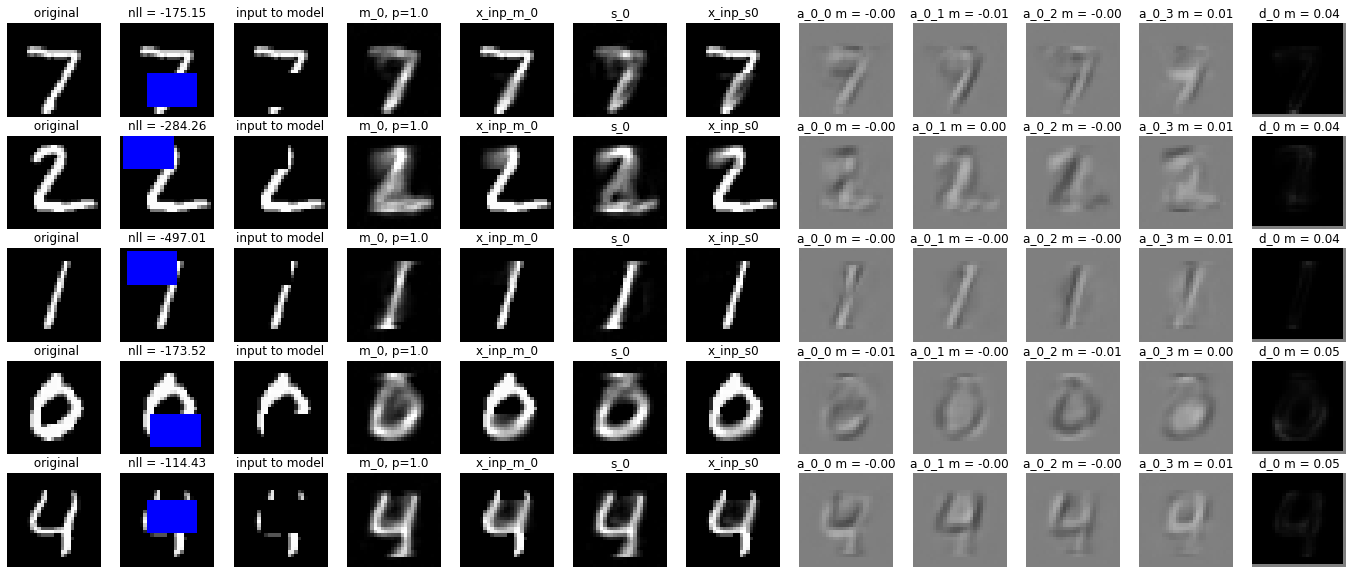

In [16]:
n = 5
for model, metrics_with_cases in ml_metrics.items():
#     metrics_with_cases = sorted(
#         metrics_with_cases, key = lambda m_c: m_c[0]["nll"]
#     )
#     metrics_with_cases = [
#         m for m in metrics_with_cases if m[1][-1] != 1
#     ] 
    for (name, mwc) in [
        ("worst", metrics_with_cases[-n:]),
        ("best", metrics_with_cases[:n])
    ]:
        print(model, name, n)
        row_len = vis.row_length(
            *metrics_with_cases[0][1]
        )
        fig, ax = plt.subplots(nrows=n, ncols=row_len, figsize=(2* row_len, n * 2))
        for i, (m, c) in enumerate(mwc):
            vis.visualize_sample(
                *c,
                ax_row=ax[i]
            )
            ax[i, 1].set_title(
                f"nll = {m['nll']:.2f}"
            )
        plt.show()



# Skimage metrics

In [17]:
def plot_exp_images(images_dicts, figsize=(15,15)):
    width = len(images_dicts[0][0])
    height = len(images_dicts)
    fig, ax = plt.subplots(height,width, figsize=figsize)
    for i, (imgs, label) in enumerate(images_dicts):
        for j, (k, v) in enumerate(imgs.items()):
            ax[i][j].imshow(v.squeeze(), cmap="gray", vmin=0, vmax=1)
            ax[i][j].set_title(k)

# plot_exp_images(experiments_images["gmm_fullconv_10x10"][:5], figsize=(10, 5))

In [18]:
experiments_metrics = {
    name: [
        {
            "metrics": ev.images_metrics(img_dict),
            "label": label
        }
        for (img_dict, label) in img_dicts
    ]
    for name, img_dicts in experiments_images.items()
}

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
../inpainting/evaluation/evaluation.py:82: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  "peak_signal_noise_ratio": lambda i1, i2,: peak_signal_noise_ratio(i1, i2)


In [19]:
per_image_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "label": label_metric["label"],
        **metric
    }
    for model, label_metrics in experiments_metrics.items()
    for label_metric in label_metrics
    for metric in label_metric["metrics"] #if metric["img_kind"] #in ["inpainted_means_0", "inpainted_samples_0"]
])
per_image_metrics_df

,imputer_model,label,img_kind,structural_similarity,peak_signal_noise_ratio
0,torch_mfa,"([7], 130.52943420410156)",original,1.000000,inf
1,torch_mfa,"([7], 130.52943420410156)",mask,0.001631,1.168067
2,torch_mfa,"([7], 130.52943420410156)",masked,0.774209,15.700145
3,torch_mfa,"([7], 130.52943420410156)",means_0,0.952007,24.767310
4,torch_mfa,"([7], 130.52943420410156)",inpainted_means_0,0.952007,24.767310
...,...,...,...,...,...
139995,gmm_linear_heads,6,masked,0.701058,12.060953
139996,gmm_linear_heads,6,means_0,0.721540,15.049013
139997,gmm_linear_heads,6,inpainted_means_0,0.915072,19.939617
139998,gmm_linear_heads,6,samples_0,0.650194,13.695951


In [20]:
per_image_metrics_df.drop("label", axis=1).groupby(
    ["imputer_model", "img_kind"]
).agg(
    lambda pts: "{0:.2f} ± {1:.2f}".format(np.mean(pts), np.std(pts) )
     ).reset_index().to_csv("mnist_ssim_psnr.csv")

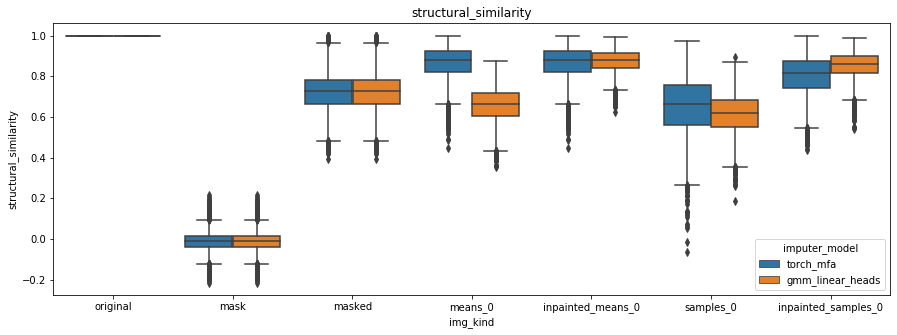

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/sit

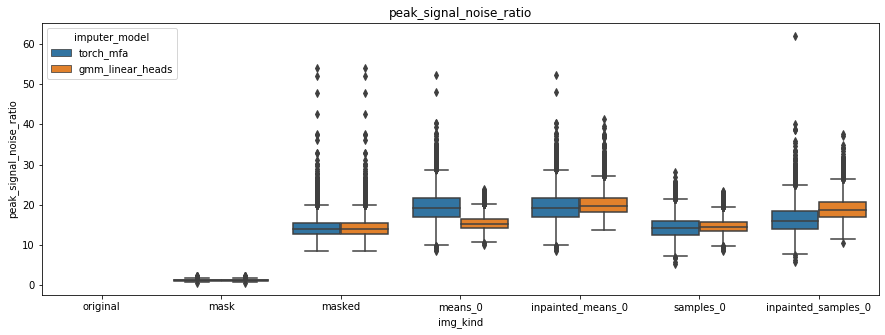

In [21]:
for metric in ["structural_similarity", "peak_signal_noise_ratio"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=per_image_metrics_df,
        y=metric,
        x="img_kind",
        hue="imputer_model"
    )
    plt.show()

# Example inpaintings of the same digit

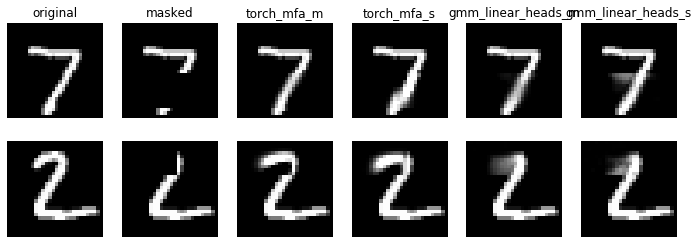

In [22]:
n_rows = 2
n_cols = (len(experiments_images.keys())*2) + 2
fig, ax = plt.subplots(
    nrows=n_rows, 
    ncols=n_cols,
    figsize=(n_cols*2, n_rows*2)
)
for i, (exp_name, imgs) in enumerate(experiments_images.items()):
    for c, img_name, brief_name in [
        ((2*i) + 2, "inpainted_means_0", "m"),
        ((2*i) + 3, "inpainted_samples_0", "s")        
    ]:
        ax[0, c].set_title(f"{exp_name}_{brief_name}")
        for j in range(n_rows):
            ax[j,c].imshow(imgs[j][0][img_name].squeeze(), vmin=0, vmax=1, cmap="gray")
            ax[j,c].axis("off")
    if i == 0:
        for c, img_name in [
            (0, "original"),
            (1, "masked")        
        ]:
            ax[0, c].set_title(f"{img_name}")
            for j in range(n_rows):
                ax[j,c].imshow(imgs[j][0][img_name].squeeze(), vmin=0, vmax=1, cmap="gray")
                ax[j,c].axis("off")
                


# More visualizations

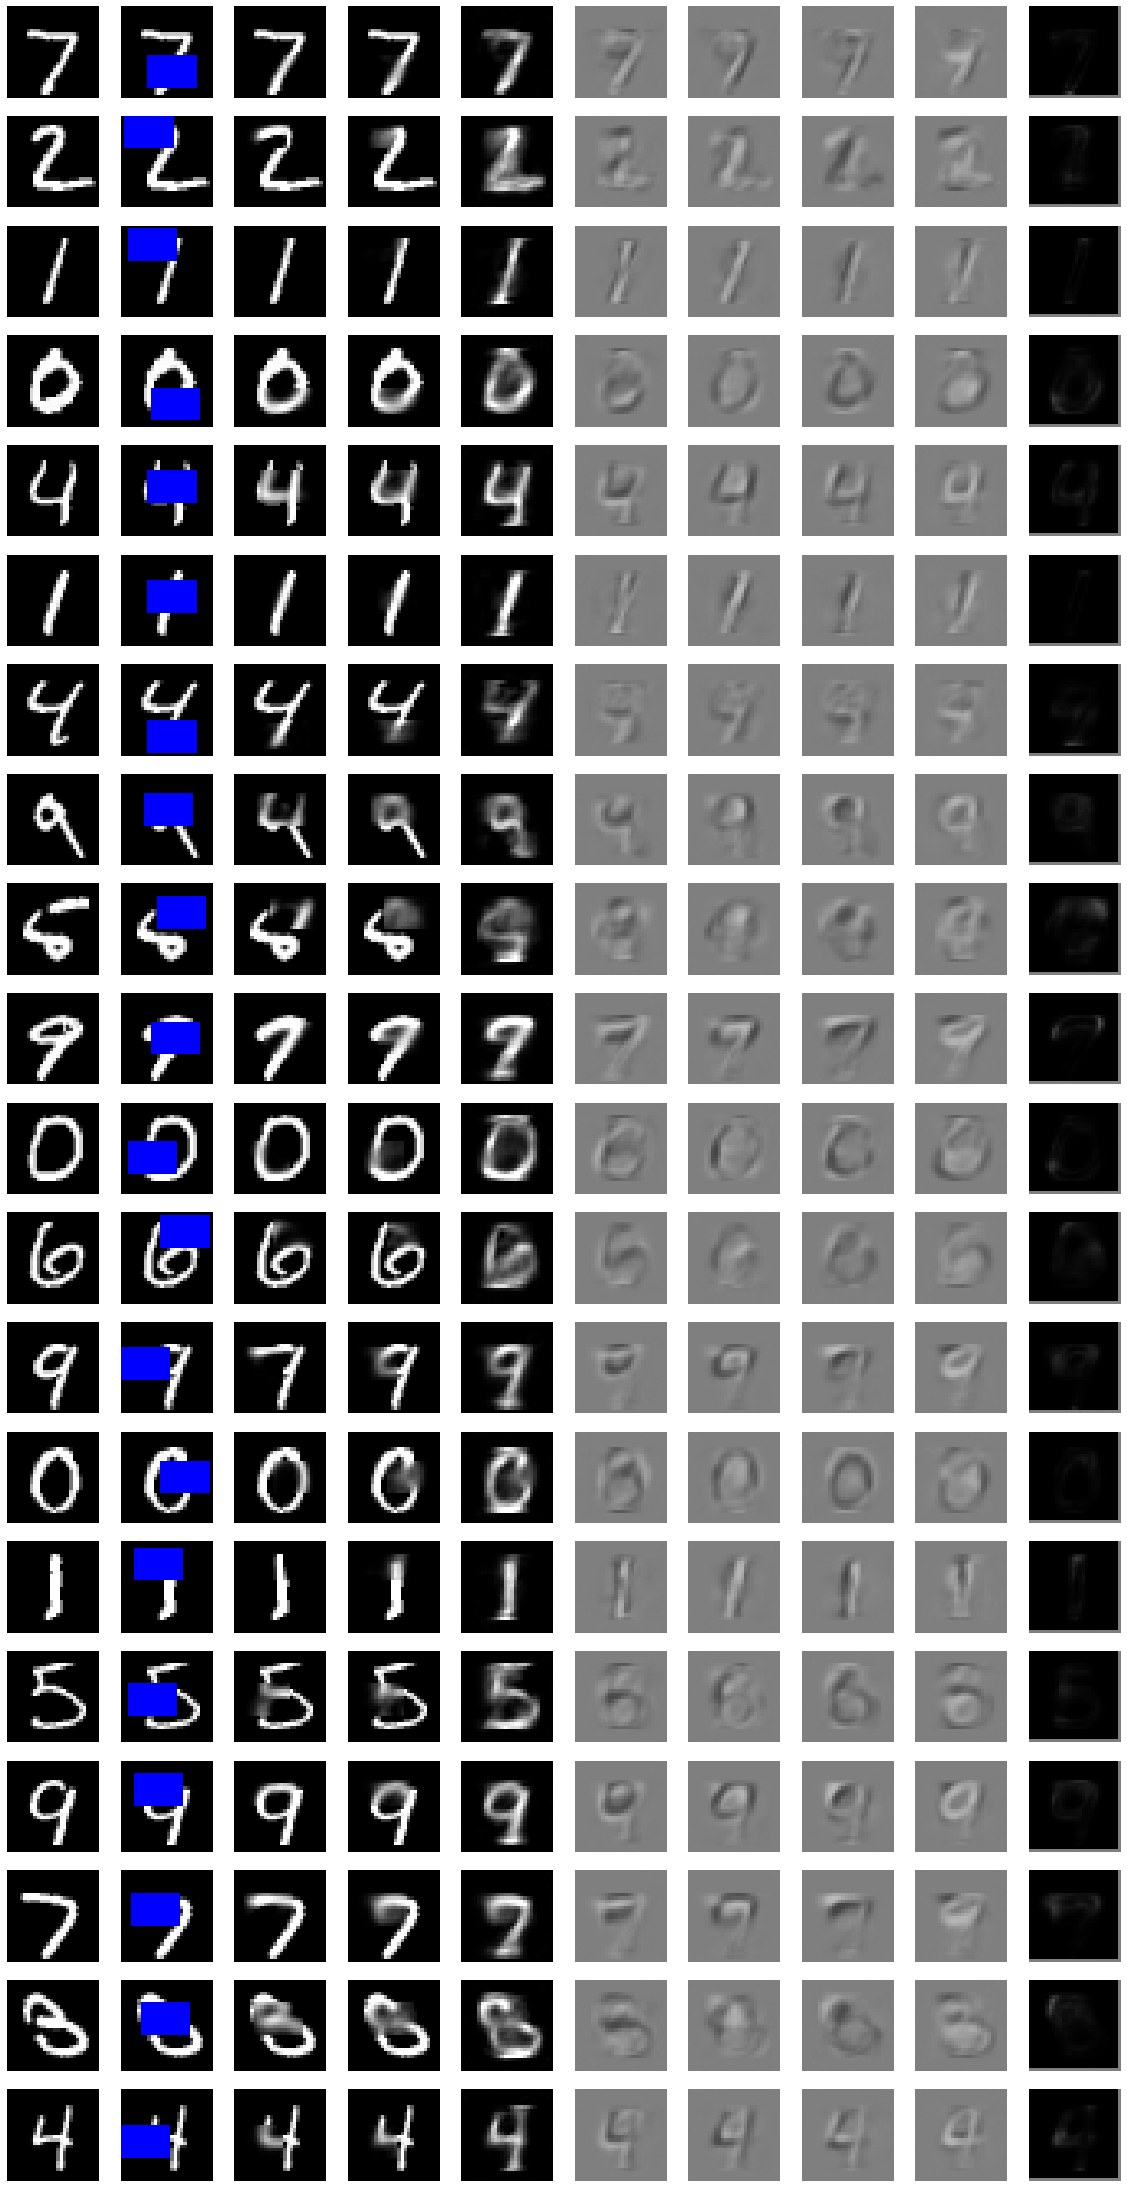

In [23]:
n_rows = 20
n_cols = 10
fig, ax = plt.subplots(
    nrows=n_rows, 
    ncols=n_cols,
    figsize=(n_cols*2, n_rows*2)
)

for i in range(n_rows):
    row_ax = ax[i]
    our_sample = experiments_results["gmm_linear_heads"][i]
    torch_mfa_sample = experiments_images["torch_mfa"][i][0]
#     _, dummy_ax = plt.subplots(vis.row_length(*sample))
    
    vis.visualize_sample_for_paper(
        our_sample,
         torch_mfa_sample,
        ax_row=row_ax
    )

fig.savefig("mnist_mosaic.png")

# Frechet distance

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ds_train = MNIST(Path.home() / "uj" / "data", train=True, download=True, transform=ToTensor())
ds_val = MNIST(Path.home() / "uj" / "data", train=False, download=True, transform=ToTensor())

dl_train = DataLoader(ds_train, 1024, shuffle=True)
dl_val = DataLoader(ds_val, 256, shuffle=False)

classifier = MNISTNet()
opt = Adam(classifier.parameters(), 4e-3)
loss_fn = CrossEntropyLoss()

classifier.to(device)
for i in range(5):
    classifier.train()
    for X, y in tqdm(dl_train):
        opt.zero_grad()
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
    classifier.eval()
    accs = []
    for (X,y ) in dl_val:
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        logits = y_pred.argmax(1)
        accs.append(accuracy_score(y.cpu().numpy(), logits.cpu().numpy()))
    print(i, np.mean(accs))

In [ ]:
def images_loader(
    images,
    batch_size = 256
):
    return DataLoader(
        TensorDataset(
            torch.Tensor([
                img.transpose(2, 0, 1)
                for img in images
            ])
        ),
        batch_size=batch_size
    )
    

def frechet_distance(
    images_loader_1,
    images_loader_2,
    model=classifier
):
    (mu_1, s_1), (mu_2, s_2) = [
        fid.calculate_activation_statistics(
            il,
            len(il.dataset),
            model,
            feature_dim=128,
        )
        for il in [images_loader_1, images_loader_2]
    ]
    return fid.calculate_frechet_distance(
        mu_1, s_1, mu_2, s_2
    )

def grouped_by_kinds(images_dicts):
    return {
        k: [
            i_d[k] for (i_d, _) in images_dicts
        ]
        for k in images_dicts[0][0].keys()
    }
    


In [ ]:
experiments_images_by_kinds = {
    name: grouped_by_kinds(img_dicts)
    for name, img_dicts in experiments_images.items()
}

In [ ]:
frechet_dists = {
    name: {
        kind: frechet_distance(
            images_loader(kind_to_images["original"]),
            images_loader(images)
            )
        for kind, images in kind_to_images.items()
    }
    for name, kind_to_images in experiments_images_by_kinds.items()
}

In [ ]:
frechet_dists_df = pd.DataFrame([
    {
        "imputer_model": name,
        "kind": kind,
        "frechet_distance": fd
    }
    for name, kind_to_fd in frechet_dists.items()
    for kind, fd in kind_to_fd.items()
])

frechet_dists_df

In [ ]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=frechet_dists_df,
    y="frechet_distance",
    x="kind",
    hue="imputer_model",
)

In [ ]:
frechet_dists_df.to_csv("frechet_dists_tmp.csv")